# **Cell segmentation**

## **Introduction**

This is the second script in the processing pipeline for IMC data.

The goal is to generate cell segmentation masks using the [Mesmer segmentation deep learning model](https://doi.org/10.1038/s41587-021-01094-0) via the [deepcell library](https://github.com/vanvalenlab/deepcell-tf). `steinbock` documentation for deepcell segmentation can be found [here](https://bodenmillergroup.github.io/steinbock/latest/cli/segmentation/#deepcell).  
 
For cell segmentation, channels corresponding to nuclear and to membrane-specific marker(s) are subset to generate two-channel image stacks that are used as the input to the Mesmer application. After applying segmentation, the quality of the masks is verified visually.  
Post-processing parameters can be adjusted to improve the segmentation.

## **Configuration** 
### **Import packages**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
import sys

from cv2 import addWeighted
from deepcell.applications import Mesmer
from matplotlib.colors import ListedColormap
from skimage import color, exposure
from skimage.segmentation import expand_labels, mark_boundaries
from tqdm import tqdm


from steinbock import io
from steinbock.segmentation import deepcell

print(sys.path)
print(sys.executable)

2024-11-15 08:07:01.235731: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.9/site-packages/cv2/../../lib64:
2024-11-15 08:07:01.235789: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


['/home/T1D_preprocessing', '/opt/conda/lib/python39.zip', '/opt/conda/lib/python3.9', '/opt/conda/lib/python3.9/lib-dynload', '', '/opt/conda/lib/python3.9/site-packages']
/opt/conda/bin/python


In [2]:
%cd /home/processing

/home/processing


### **Load directories and panels**
 
Paths to input and output folders as well as antibody panels were exported by the first script (`01_Preprocessing.ipynb`). Here they are imported again.

In [3]:
with open("./variables/folders.txt", "rb") as handle:
    folders = pickle.loads(handle.read())
folders

with open("./variables/panels.txt", "rb") as handle:
    panels = pickle.loads(handle.read())

for panel_name, panel in panels.items():
    print(panel_name, "\n", panel.head())
panel_names = list(panels.keys())

Uncompressed 
    channel  metal                     name    antibody_clone  keep  deepcell  \
0        0  In113               Histone H3              D1H2     1       1.0   
1        1  In115                      SMA               1A4     1       2.0   
5        5  Pr141                  insulin             C27C9     1       0.0   
6        6  Nd143                     CD44               IM7     1       2.0   
7        7  Nd144  Prohormone Convertase 2  Polyclonal _ PC2     1       0.0   

   clustering  dimred shortname  
0           0       0        H3  
1           1       1       SMA  
5           1       1       INS  
6           1       1      CD44  
7           1       1     PCSK2  
Compressed 
    channel  metal                     name  antibody_clone  keep  deepcell  \
0        0  In113               Histone H3            D1H2     1       1.0   
1        1  In115                      SMA             1A4     1       2.0   
5        5  Nd143                 CD44_GCG      IM7_D

## **Prepare cell segmentation**
 
### **Generate segmentation stacks**

Segmentation stacks are generated by aggregating the channels selcted in `panel.csv` in the column `deepcell`.  

Cell segmentation requires to construct as 2-channel images with the following structure:
+ Channel 1 = nuclear channels.
+ Channel 2 = cytoplasmic/membranous channels.
 
For channel-wise normalization, zscore and min-max methods are available.  
In addition, different functions can be used to aggregate channels. Default: `np.mean`, for other options, see https://numpy.org/doc/stable/reference/routines.statistics.html#averages-and-variances.


In [4]:
# Define image preprocessing options
channelwise_zscore = False
channelwise_minmax = True
aggr_func = np.sum


for panel_name, panel in panels.items():
    print("Processing", panel_name, "panel")
    # Define channels to use for segmentation ("islet_seg" column in panel(s))
    channel_groups = panel["deepcell"].values
    channel_groups = np.where(channel_groups == 0, np.nan, channel_groups)
    
    # Define input/output folders
    img_subdir = folders["img"] / panel_name
    seg_subdir = folders["seg_cells"] / panel_name
    seg_subdir.mkdir(exist_ok=True)

    # Create and save segmentation stacks
    for img_path in io.list_image_files(img_subdir):
        segstack = deepcell.create_segmentation_stack(
            img = io.read_image(img_path),
            channelwise_minmax = channelwise_minmax,
            channelwise_zscore = channelwise_zscore,
            channel_groups = channel_groups,
            aggr_func = aggr_func
        )
        segstack_file = seg_subdir / f"{img_path.name}"
        io.write_image(segstack, segstack_file)


Processing Uncompressed panel
Processing Compressed panel


### **Check segmentation stacks**
 
Subset nuclear and cytoplasmic/membraneous channels are shown side-by-side
 
#### **Parameters**

In [5]:
# Number of images per panel to show
nb_images_to_show = 5

# Adjust image max intensity if needed (lower value = higher intensity)
max_intensity_nuc = 0.75
max_intensity_mem = 0.5

#### **Display nuclear and membranous channels**

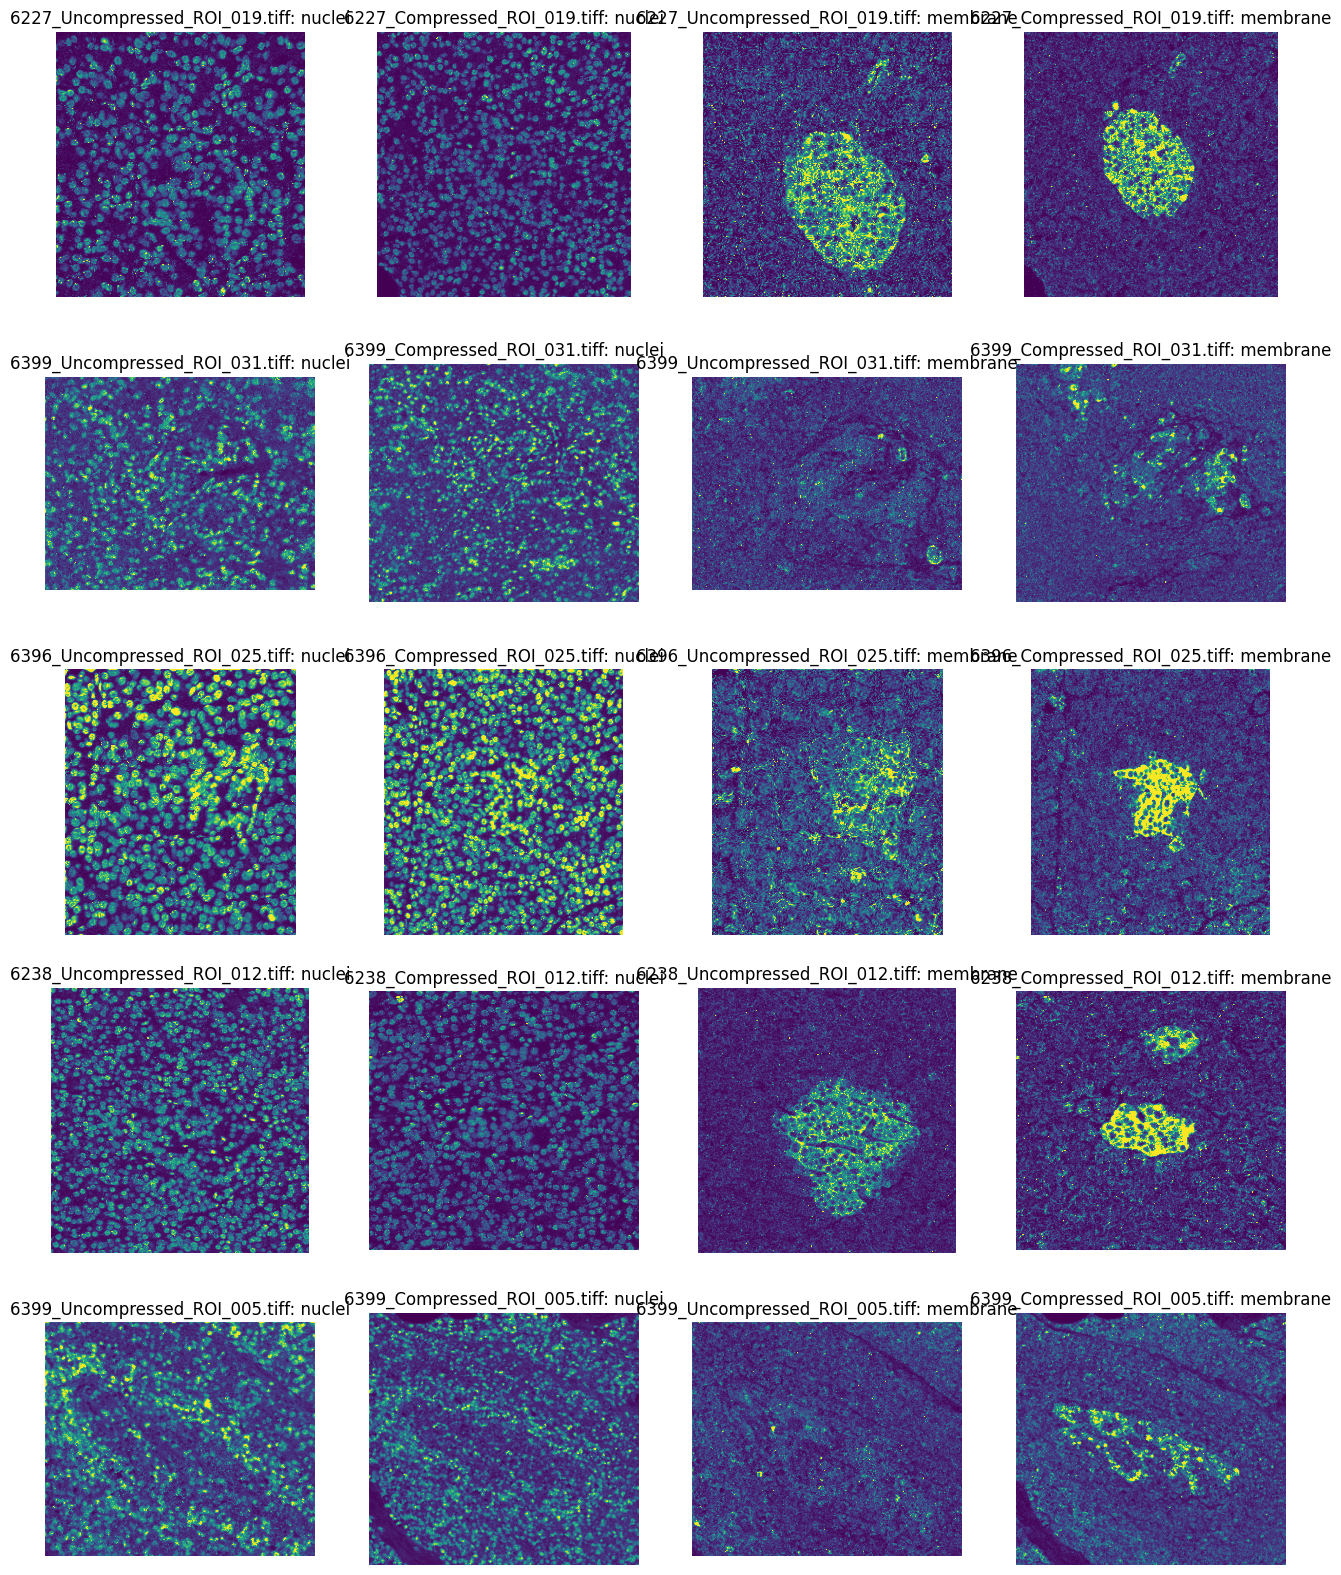

In [6]:
# Randomly select images
segstacks_dir0 = folders["seg_cells"] / panel_names[0]
segstacks = sorted(segstacks_dir0.glob("*.tiff"))
rng = np.random.default_rng()
indexes = rng.choice(len(segstacks), nb_images_to_show, replace=False)

# Plot
fig, axs = plt.subplots(nb_images_to_show, 4,
                        figsize=(16, 4*nb_images_to_show))

for i,idx in enumerate(indexes):
    for j, (panel_name, panel) in enumerate(panels.items()):
        
        ## load images and masks
        seg_subdir = folders["seg_cells"] / panel_name
        img_name = segstacks[idx].name.replace(panel_names[0], panel_name)
        img = io.read_image(seg_subdir / img_name)
        
        ## plot images
        axs[i,j].imshow(img[0,:,:], vmin=0, vmax=max_intensity_nuc)
        axs[i,j].set_title(img_name + ": nuclei")
        axs[i,j].axis('off')

        axs[i,j+2].imshow(img[1,:,:], vmin=0, vmax=max_intensity_mem)
        axs[i,j+2].set_title(img_name + ": membrane")
        axs[i,j+2].axis('off')

## **Segment cells**
 
### **Settings**
 
`segmentation_type` should be one either `whole-cell` or `nuclear`.  
 
The image resolution should also be specified (microns per pixel).
 
Several post-processing arguments can be passed to the deepcell application. Defaults for nuclear and whole-cell segmentation are indicated in brackets.
- `maxima_threshold`: set lower if cells are missing (default for nuclear segmentation=0.1, default for nuclear segmentation=0.075).
- `maxima_smooth`: (default=0).
- `interior_threshold`: set higher if you your nuclei are too large (default=0.2).
- `interior_smooth`: larger values give rounder cells (default=2).
- `small_objects_threshold`: depends on the image resolution (default=50).
- `fill_holes_threshold`: (default=10).  
- `radius`: (default=2).
 
Cell labels can also be expanded by defining an `expansion_distance` (mostly useful for nuclear segmentation).


In [7]:
# Segmentation type
segmentation_type = "whole-cell" # "nuclear"

# Post-processing arguments for whole-cell segmentation
kwargs_whole_cell =  {
    'maxima_threshold': 0.075,
    'maxima_smooth': 0,
    'interior_threshold': 0.2,
    'interior_smooth': 2,
    'small_objects_threshold': 25,
    'fill_holes_threshold': 15,
    'radius': 2
}

# Post-processing arguments for nuclear segmentation
kwargs_nuclear =  {
    'maxima_threshold': 0.1,
    'maxima_smooth': 0,
    'interior_threshold': 0.2,
    'interior_smooth': 2,
    'small_objects_threshold': 15,
    'fill_holes_threshold': 15,
    'radius': 2
}

# Mask pixel expansion (0 = no expansion)
expansion_distance = 0

# Image resolution (microns per pixels)
image_mpp = 1

### **Predict cell masks**

In [8]:
app = Mesmer()


for panel_name, panel in panels.items():
    
    # Input/output
    print("Processing", panel_name, "panel")
    seg_subdir = folders["seg_cells"] / panel_name
    masks_dir = folders["masks_cells"] / panel_name
    masks_dir.mkdir(exist_ok = True)
    masks_subdir = masks_dir / segmentation_type
    masks_subdir.mkdir(exist_ok = True)
    segstacks = io.list_image_files(seg_subdir)
    
    for stack in tqdm(segstacks):
        
        # Load images
        img = io.read_image(stack)
        img = np.moveaxis(img, 0, 2)
        img = np.expand_dims(img.data, 0)

        # Predict masks
        mask = app.predict(
            img, image_mpp = image_mpp, compartment = segmentation_type,
            postprocess_kwargs_whole_cell = kwargs_whole_cell,
            postprocess_kwargs_nuclear = kwargs_nuclear
        )
        mask = mask.squeeze()
        mask = expand_labels(mask, distance = float(expansion_distance))

        # Save masks
        mask_file = masks_subdir / stack.name
        io.write_mask(mask, mask_file)


2024-11-15 08:08:46.263318: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.9/site-packages/cv2/../../lib64:
2024-11-15 08:08:46.263414: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-11-15 08:08:46.263444: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (68b1348b7767): /proc/driver/nvidia/version does not exist
2024-11-15 08:08:46.264050: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Processing Uncompressed panel


  0%|          | 0/113 [00:00<?, ?it/s]/opt/conda/lib/python3.9/site-packages/deepcell_toolbox/deep_watershed.py:179: FutureWarning: `selem` is a deprecated argument name for `h_maxima`. It will be removed in version 1.0. Please use `footprint` instead.
  markers = h_maxima(image=maxima,
100%|██████████| 113/113 [03:45<00:00,  1.99s/it]


Processing Compressed panel


100%|██████████| 113/113 [06:01<00:00,  3.20s/it]


The next step in this pipeline is measurement of cell intensities, which is performed with the 03_Measurements.ipynb notebook.

In [9]:
!conda list

# packages in environment at /opt/conda:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                        main  
_openmp_mutex             4.5                       1_gnu  
absl-py                   1.3.0                    pypi_0    pypi
albumentations            1.3.0                    pypi_0    pypi
anndata                   0.8.0                    pypi_0    pypi
anyio                     3.5.0            py39h06a4308_0  
argon2-cffi               21.3.0             pyhd3eb1b0_0  
argon2-cffi-bindings      21.2.0           py39h7f8727e_0  
asttokens                 2.0.5              pyhd3eb1b0_0  
astunparse                1.6.3                    pypi_0    pypi
attrs                     22.1.0           py39h06a4308_0  
babel                     2.9.1              pyhd3eb1b0_0  
backcall                  0.2.0              pyhd3eb1b0_0  
beautifulsoup4            4.11.1           py39h06a4308_0  
blas                      